## LOGIT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import patsy as patsy
from patsy import ModelDesc
from patsy import dmatrices
from patsy import ModelDesc, Term, EvalFactor
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.discrete.discrete_model import Probit
import operator
import math
import seaborn as sns
import statsmodels

# Data

In [2]:
df_MIDBFR = pd.read_csv('frequencyMID.csv',sep=";")
df_MIDB = pd.read_csv('BINARYTABLE.csv', sep=";")
Year = df_MIDBFR['YEAR']

# Lagged Variables

In [33]:
country = 'USA'
FirstPredictedYear = 2015
row= FirstPredictedYear - 1816
row2= row + 1
row3= row2 + 1
row4= row3 + 1
row5= row4 + 1
inter_confl = df_MIDB[country]
s3 = pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan])
inter_confl=inter_confl.append(s3,ignore_index=True)
inter_confl=inter_confl.rename(country + "Conflict")

inter_freq = df_MIDBFR[country]
s3 = pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan])
inter_freq=inter_freq.append(s3,ignore_index=True)
inter_freq=inter_freq.rename(country + "Frequency")
inter_freq1 = inter_freq.shift(1)
inter_freq1 = inter_freq1.rename("L1_"+ country +"Frequency")
inter_freq2 = inter_freq1.shift(1)
inter_freq2 = inter_freq2.rename("L2_"+ country +"Frequency")
inter_freq3 = inter_freq2.shift(1)
inter_freq3 = inter_freq3.rename("L3_"+ country +"Frequency")
inter_freq4 = inter_freq3.shift(1)
inter_freq4 = inter_freq4.rename("L4_"+ country +"Frequency")
inter_freq5 = inter_freq4.shift(1)
inter_freq5 = inter_freq5.rename("L5_"+ country +"Frequency")

inter_lagged = inter_confl.shift(1)
inter_lagged = inter_lagged.rename("L1_" + country + "Conflict")
inter_lagged2 = inter_lagged.shift(1)
inter_lagged2 = inter_lagged2.rename("L2_"+ country +"Conflict")
inter_lagged3 = inter_lagged2.shift(1)
inter_lagged3 = inter_lagged3.rename("L3_"+ country +"Conflict")
inter_lagged4 = inter_lagged3.shift(1)
inter_lagged4 = inter_lagged4.rename("L4_"+ country +"Conflict")
inter_lagged5 = inter_lagged4.shift(1)
inter_lagged5 = inter_lagged5.rename("L5_"+ country +"Conflict")
data_confl = pd.concat([inter_confl, inter_lagged, inter_lagged2, inter_lagged3, inter_lagged4, inter_lagged5, inter_freq, inter_freq1, inter_freq2, inter_freq3, inter_freq4, inter_freq5],axis=1)
data_confl

,UKGConflict,L1_UKGConflict,L2_UKGConflict,L3_UKGConflict,L4_UKGConflict,L5_UKGConflict,UKGFrequency,L1_UKGFrequency,L2_UKGFrequency,L3_UKGFrequency,L4_UKGFrequency,L5_UKGFrequency
0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
199,NaN,1.0,1.0,1.0,1.0,0.0,NaN,2.0,3.0,2.0,2.0,0.0
200,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,2.0,3.0,2.0,2.0
201,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,2.0,3.0,2.0
202,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2.0,3.0


# Poisson Regression for Frequency

In [34]:
#Poisson to predict frequency of unobserved year

Z, K = dmatrices(country + 'Frequency'+ '~' + 'L1_'+country+'Frequency + L2_' +country+'Frequency + L3_' +country+ 'Frequency + L4_' 
                 +country+ 'Frequency + L5_' +country+ 'Frequency', NA_action=patsy.NAAction(NA_types=[]), data=data_confl, return_type='dataframe')

def remove_most_insignificant(df, results):
    max_p_value = max(results.pvalues.iteritems(), key=operator.itemgetter(1))[0]
    df.drop(columns = max_p_value, inplace = True)
    return df

insignificant_feature = True
while insignificant_feature:
    modelFR = sm.Poisson(Z, K,missing='drop')
    resultsFR = modelFR.fit(cov_type='HC3')
    significant = [p_value < 0.05 for p_value in resultsFR.pvalues[1:]]
    if all(significant):
        insignificant_feature = False
    else:
        if K.shape[1] == 1:
            print('No significant features found')
            resultsFR = None
            insignificant_feature = False
        else:
            K = remove_most_insignificant(K, resultsFR)

print(resultsFR.summary())

signif_valuesFR = resultsFR.params.to_frame()
signif_valuesFR = signif_valuesFR.reset_index()
signif_valuesFR.columns = ['sign_variable','coef']


zeta_1 = signif_valuesFR[signif_valuesFR['sign_variable'] == 'L1_'+ country + 'Frequency'] ['coef'].values
zeta_2 = signif_valuesFR[signif_valuesFR['sign_variable'] == 'L2_'+ country + 'Frequency'] ['coef'].values
zeta_3 = signif_valuesFR[signif_valuesFR['sign_variable'] == 'L3_'+ country + 'Frequency'] ['coef'].values
zeta_4 = signif_valuesFR[signif_valuesFR['sign_variable'] == 'L4_'+ country + 'Frequency'] ['coef'].values
zeta_5 = signif_valuesFR[signif_valuesFR['sign_variable'] == 'L5_'+ country + 'Frequency'] ['coef'].values

interceptFR = signif_valuesFR[signif_valuesFR['sign_variable'] == 'Intercept'] ['coef'].values
if zeta_1.size <= 0:
    zeta_1 = 0

if zeta_2.size <= 0:
    zeta_2 = 0

if zeta_3.size <= 0:
    zeta_3 = 0

if zeta_4.size <= 0:
    zeta_4 = 0

if zeta_5.size <= 0:
    zeta_5 = 0

Optimization terminated successfully.
         Current function value: 1.659471
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.661676
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.664141
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.661801
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:           UKGFrequency   No. Observations:                  196
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Jan 2021   Pseudo R-squ.:                 0.08933
Time:                        22:29:36   Log-Likelihood:                -325.71
converged:                       True   LL-Null:                       -357.66
Covariance Type:                  HC3  

In [35]:
Frequency1year = interceptFR + (zeta_1 * data_confl['L1_' +country+ 'Frequency'][row]) + (zeta_2 * data_confl['L2_' +country+ 'Frequency'][row]) + (zeta_3 * data_confl['L3_' +country+ 'Frequency'][row]) + (zeta_4 * data_confl['L4_' +country+ 'Frequency'][row]) + (zeta_5 * data_confl['L5_' +country+ 'Frequency'][row])
Frequency1year = math.exp(Frequency1year)
Frequency2year = interceptFR + (zeta_1 * Frequency1year) + (zeta_2 * data_confl['L2_' +country+ 'Frequency'][row2]) + (zeta_3 * data_confl['L3_' +country+ 'Frequency'][row2]) + (zeta_4 * data_confl['L4_' +country+ 'Frequency'][row2]) + (zeta_5 * data_confl['L5_' +country+ 'Frequency'][row2])
Frequency2year = math.exp(Frequency2year)
Frequency3year = interceptFR + (zeta_1 * Frequency2year) + (zeta_2 * Frequency1year) + (zeta_3 * data_confl['L3_' +country+ 'Frequency'][row3]) + (zeta_4 * data_confl['L4_' +country+ 'Frequency'][row3]) + (zeta_5 * data_confl['L5_' +country+ 'Frequency'][row3])
Frequency3year = math.exp(Frequency3year)
Frequency4year = interceptFR + (zeta_1 * Frequency3year) + (zeta_2 * Frequency2year) + (zeta_3 * Frequency1year) + (zeta_4 * data_confl['L4_' +country+ 'Frequency'][row4]) + (zeta_5 * data_confl['L5_' +country+ 'Frequency'][row4])
Frequency4year = math.exp(Frequency4year)
Frequency5year = interceptFR + (zeta_1 * Frequency4year) + (zeta_2 * Frequency3year) + (zeta_3 * Frequency2year) + (zeta_4 * Frequency1year) + (zeta_5 * data_confl['L5_' +country+ 'Frequency'][row5])
Frequency5year = math.exp(Frequency5year)
print(Frequency1year)
print(Frequency2year)
print(Frequency3year)
print(Frequency4year)
print(Frequency5year)

1.7581855555855048
1.7859839798291284
1.7033872815027506
1.6618875508040523
1.6540796907503512


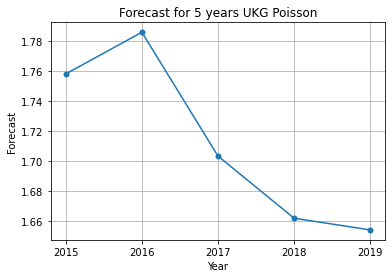

In [36]:
forecast_poisson = [Frequency1year,Frequency2year,Frequency3year,Frequency4year,Frequency5year]
x = ['2015','2016','2017','2018','2019']
plt.title('Forecast for 5 years ' + country + ' Poisson')
plt.xlabel('Year') 
plt.ylabel('Forecast')
plt.grid()
plt.plot(x,forecast_poisson, 'o-', markeredgewidth=0)
plt.savefig(country + '_5years_forecast_Poisson.png')


## Logit

In [37]:
#Now that we have all data we can use LOGIT to predict
Y, X = dmatrices(country + 'Conflict'+ '~' + ' L1_'+ country + 'Conflict + L2_'+ country + 'Conflict + L3_'+ country +'Conflict + L4_'+ country +
                 'Conflict + L5_'+ country +'Conflict + L1_'+country+'Frequency + L2_' +country+'Frequency + L3_' +country+ 'Frequency + L4_' 
                 +country+ 'Frequency + L5_' +country+ 'Frequency', NA_action=patsy.NAAction(NA_types=[]), data=data_confl, return_type='dataframe')



def remove_most_insignificant(df, results):
    max_p_value = max(results.pvalues.iteritems(), key=operator.itemgetter(1))[0]
    df.drop(columns = max_p_value, inplace = True)
    return df

insignificant_feature = True
while insignificant_feature:
    model = sm.Logit(Y, X,missing='drop')
    results = model.fit()
    significant = [p_value < 0.05 for p_value in results.pvalues[1:]]
    if all(significant):
        insignificant_feature = False
    else:
        if X.shape[1] == 1:
            print('No significant features found')
            results = None
            insignificant_feature = False
        else:
            X = remove_most_insignificant(X, results)

print(results.summary())

signif_values = results.params.to_frame()
signif_values = signif_values.reset_index()
signif_values.columns = ['sign_variable','coef']
beta1 = signif_values[signif_values['sign_variable'] == 'L1_' + country + 'Conflict'] ['coef'].values
beta2 = signif_values[signif_values['sign_variable'] == 'L2_' + country + 'Conflict'] ['coef'].values
beta3 = signif_values[signif_values['sign_variable'] == 'L3_' + country + 'Conflict'] ['coef'].values
beta4 = signif_values[signif_values['sign_variable'] == 'L4_' + country + 'Conflict'] ['coef'].values
beta5 = signif_values[signif_values['sign_variable'] == 'L5_' + country + 'Conflict'] ['coef'].values

theta1 = signif_values[signif_values['sign_variable'] == 'L1_'+ country + 'Frequency'] ['coef'].values
theta2 = signif_values[signif_values['sign_variable'] == 'L2_'+ country + 'Frequency'] ['coef'].values
theta3 = signif_values[signif_values['sign_variable'] == 'L3_'+ country + 'Frequency'] ['coef'].values
theta4 = signif_values[signif_values['sign_variable'] == 'L4_'+ country + 'Frequency'] ['coef'].values
theta5 = signif_values[signif_values['sign_variable'] == 'L5_'+ country + 'Frequency'] ['coef'].values

intercept = signif_values[signif_values['sign_variable'] == 'Intercept'] ['coef'].values

if theta1.size <= 0:
    theta1 = 0
    
if theta2.size <= 0:
    theta2 = 0
    
if theta3.size <= 0:
    theta3 = 0
    
if theta4.size <= 0:
    theta4 = 0
    
if theta5.size <= 0:
    theta5 = 0

if beta1.size <= 0:
    beta1 = 0
    
if beta2.size <= 0:
    beta2 = 0
    
if beta3.size <= 0:
    beta3 = 0
    
if beta4.size <= 0:
    beta4 = 0
    
if beta5.size <= 0:
    beta5 = 0

Optimization terminated successfully.
         Current function value: 0.421407
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421408
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421421
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421426
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421899
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426271
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429219
         Iterations 7
                           Logit Regression Results                           
Dep

## AIC & BIC

In [38]:
print(results.aic)
print(results.bic)

175.112262630494
184.96187381670796


In [29]:
Y1year = intercept + beta1 * data_confl['L1_' +country+ 'Conflict'][row] + beta2 * data_confl['L2_' +country+ 'Conflict'][row] + beta3 * data_confl['L3_' +country+ 'Conflict'][row] + beta4 * data_confl['L4_' +country+ 'Conflict'][row] + beta5 * data_confl['L5_' +country+ 'Conflict'][row] + theta1 * data_confl['L1_' +country+ 'Frequency'][row] + theta2 * data_confl['L2_' +country+ 'Frequency'][row] + theta3 * data_confl['L3_' +country+ 'Frequency'][row] + theta4 * data_confl['L4_' +country+ 'Frequency'][row] + theta5 * data_confl['L5_' +country+ 'Frequency'][row]
P1year = math.exp(Y1year)/(1+(math.exp(Y1year)))
Y2year = intercept + beta1 * P1year + beta2 * data_confl['L2_' +country+ 'Conflict'][row2] + beta3 * data_confl['L3_' +country+ 'Conflict'][row2] + beta4 * data_confl['L4_' +country+ 'Conflict'][row2] + beta5 * data_confl['L5_' +country+ 'Conflict'][row2] + theta1 * Frequency1year + theta2 * data_confl['L2_' +country+ 'Frequency'][row2] + theta3 * data_confl['L3_' +country+ 'Frequency'][row2] + theta4 * data_confl['L4_' +country+ 'Frequency'][row2] + theta5 * data_confl['L5_' +country+ 'Frequency'][row2]
P2year = math.exp(Y2year)/(1+(math.exp(Y2year)))
Y3year = intercept + beta1 * P2year + beta2 * P1year + beta3 * data_confl['L3_' +country+ 'Conflict'][row3] + beta4 * data_confl['L4_' +country+ 'Conflict'][row3] + beta5 * data_confl['L5_' +country+ 'Conflict'][row3] + theta1 * Frequency2year + theta2 * Frequency1year + theta3 * data_confl['L3_' +country+ 'Frequency'][row3] + theta4 * data_confl['L4_' +country+ 'Frequency'][row3] + theta5 * data_confl['L5_' +country+ 'Frequency'][row3]
P3year = math.exp(Y3year)/(1+(math.exp(Y3year)))
Y4year = intercept + beta1 * P3year + beta2 * P2year + beta3 * P1year + beta4 * data_confl['L4_' +country+ 'Conflict'][row4] + beta5 * data_confl['L5_' +country+ 'Conflict'][row4] + theta1 * Frequency3year + theta2 * Frequency2year + theta3 * Frequency1year + theta4 * data_confl['L4_' +country+ 'Frequency'][row4] + theta5 * data_confl['L5_' +country+ 'Frequency'][row4]
P4year = math.exp(Y4year)/(1+(math.exp(Y4year)))
Y5year = intercept + beta1 * P4year + beta2 * P3year + beta3 * P2year + beta4 * P1year + beta5 * data_confl['L5_' +country+ 'Conflict'][row5] + theta1 * Frequency4year + theta2 * Frequency3year + theta3 * Frequency2year + theta4 * Frequency1year + theta5 * data_confl['L5_' +country+ 'Frequency'][row5]
P5year = math.exp(Y5year)/(1+(math.exp(Y5year)))
#probabilities
print(P1year)
print(P2year)
print(P3year)
print(P4year)
print(P5year)

0.9989120063310455
0.9972648957306286
0.9992088570632441
0.998510252518138
0.9984758365788776


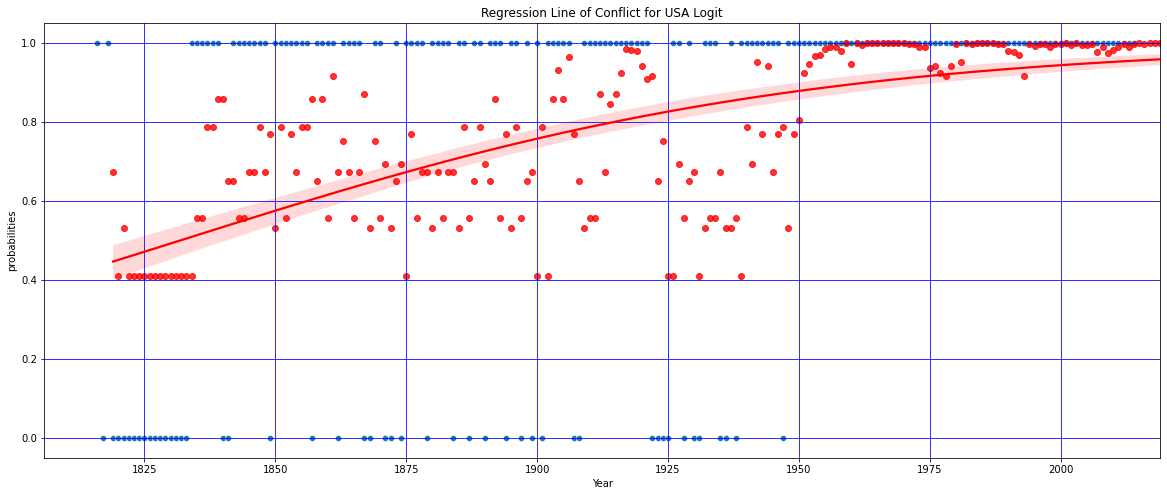

In [30]:
pred=results.predict()
preds=pd.DataFrame(pred)
forecast1=[P1year,P2year,P3year,P4year,P5year]
preds = preds.append(forecast1,ignore_index=True)
startValue=204-len(preds)


realData=df_MIDB[country]
indexYear = pd.read_csv('YearIndex.csv')[startValue:]
index2 = df_MIDB['YEAR'][:]
wide_df2 = pd.DataFrame(realData)
plt.figure(figsize=(20,8))
sns.scatterplot(y=realData,x=index2)
sns.regplot(x=indexYear,y=preds,logistic=True,scatter=True,color='red')
plt.grid(color = 'b')
plt.title('Regression Line of Conflict for ' + country + ' Logit')
plt.xlabel('Year') 
plt.ylabel('probabilities')
plt.savefig(country + '_logit_predict.png')


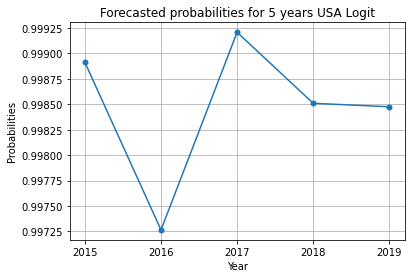

In [31]:
preds2 = [P1year,P2year,P3year,P4year,P5year]
x = ['2015','2016','2017','2018','2019']
plt.title('Forecasted probabilities for 5 years ' + country + ' Logit')
plt.xlabel('Year') 
plt.ylabel('Probabilities')
plt.grid()
plt.plot(x,preds2, 'o-', markeredgewidth=0)
plt.savefig(country + '_5years_predict_logit.png')
